In [1]:
import numpy as np
import csv

from scipy import sparse

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import warnings
from collections import Counter, defaultdict

In [2]:
def generate_dummy_dataset(n_clusters=3, n_points=100):
    data = []
    for cluster in range(n_clusters):
        mean = np.random.uniform(-10, 10, 2)
        cov = np.eye(2)
        x, y = np.random.multivariate_normal(mean=mean, cov=cov, size=n_points).T
        target_cluster = [cluster] * n_points
        
        data += list(zip(x, y, target_cluster))
        plt.scatter(x, y)

    plt.show()
    np.random.shuffle(data)
    return data

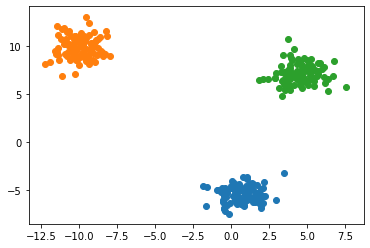

In [3]:
dummy_data = generate_dummy_dataset()
x, y, target = zip(*dummy_data)
points = np.array(list(zip(x, y)))

In [4]:
def simillarity(points):
        samples = len(points)
        a, b = points.T[np.newaxis, ...], points[..., np.newaxis]
        sim = -np.sum((a - b) ** 2, axis=1)
        median = np.median(sim)
        sim.flat[::samples + 1] = median
        return sim

def affinity_propogation(s, max_iters=1000, damping=0.5):
#     size = len(points)
#     s = simillarity(points)
    size = s.shape[0]
    r, a = np.zeros_like(s), np.zeros_like(s)
    each_ = np.arange(size)
    
    for i in tqdm(range(max_iters)):
        # Responsabilities:
        t_ = a + s
        ind_ = t_.argmax(axis=-1)
        max_ = t_[each_, ind_]
        t_[each_, ind_] = -np.inf
        max_2 = t_.max(axis=-1)
        r_ = max_[:, None].repeat(size, -1)
        r_[each_, ind_] = max_2
        r_ = s - r_
        r = (1 - damping) * r_ + damping * r
        
        # Availability:
        t_ = np.maximum(r, 0)
        t_.flat[::size+1] = r.flat[::size+1]
        t_ = np.sum(t_, 0) - t_
        diag = np.diag(t_).copy()
        t_ = np.minimum(t_, 0)
        t_.flat[::size+1] = diag
        a = (1 - damping) * t_ + damping * a
        
    
    # Get exemplars
    exemplars = (np.diag(a) + np.diag(r)) > 0
    exemplars_idx = np.flatnonzero(exemplars)
    n_clusters = len(exemplars_idx)
    labels = np.argmax(s[:, exemplars_idx], axis=1)
    labels[exemplars_idx] = np.arange(n_clusters)
    clusters = [np.where(labels == i)[0] for i in range(n_clusters)]
    
    return labels, clusters, exemplars_idx

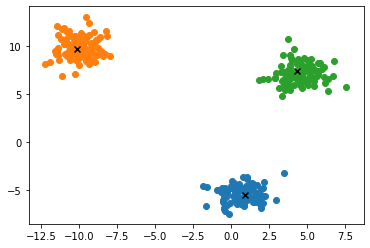

In [5]:
S = simillarity(points)
labels, clusters, idx = affinity_propogation(S, 100)
cl_points = points[idx]

for cluster in clusters:
    plt.scatter(*zip(*points[cluster]))

plt.scatter(*zip(*points[idx]), marker="x", c="black")
plt.show()

In [7]:
def load_gowalla_dataset(filename: str, test_size=1000) -> tuple:
    with open(filename) as file:
        reader = csv.reader(file, delimiter="\t")
        data = np.array([(int(a), int(b)) for a, b in reader])
    return data

In [8]:
data = load_gowalla_dataset("dataset/loc-gowalla_edges.txt")
users = set([i for p in data for i in p])
n_users = len(users)
M = sparse.coo_matrix(([1.] * len(data), zip(*data)), shape=(n_users, n_users))

In [9]:
len(set([a for a, b in data])), len(data)

(196591, 1900654)

Oh, well...

In [10]:
def sparse_affinity_propogation(s, max_iters=100, damping=0.5):
    warnings.filterwarnings('error')
    size = s.shape[0]
    s = s.tocsr()
    r = sparse.lil_matrix(s.shape)
    a = sparse.lil_matrix(s.shape)
    
    each_ = np.arange(size)
    
    for i in tqdm(range(max_iters)):
        # Responsabilities:
        t_ = s + a
        first_argmax = np.ravel(t_.argmax(-1))
        first_max = np.ravel(t_[each_, first_argmax])
        
        t__ = t_.copy()
        t__[each_, first_argmax] = -np.inf
        second_max = np.ravel(t__.max(-1).todense())
        t_ = t_.tocoo()
        r_ = sparse.lil_matrix(r.shape)
        for i, j, v in zip(t_.row, t_.col, t_.data):
            if v == first_max[i]:
                val = v - second_max[i]
            else:
                val = v - first_max[i]
            r_[i, j] = val

        r = (1 - damping) * r_ + damping * r
        r_diag = np.ravel(r.diagonal())
        r.tolil().setdiag(0)
        r_max_0 = r.maximum(0)

        # Availability:
        a_ = sparse.lil_matrix(a.shape)
        r_sum = np.ravel(r_max_0.sum(0))
        r_max_0 = r_max_0.tocoo()
        for i, k, v in zip(r_max_0.row, r_max_0.col, r_max_0.data):
            a_ik = r_diag[k] + r_sum[k] - v
            if a_ik < 0:
                a_[i, k] = a_ik

        a_ = a_.minimum(0).tocoo()
        a_.setdiag(r_sum)
        a = (1 - damping) * a_ + damping * a
        
    
    # Get exemplars
    exemplars = (np.ravel(a.diagonal()) + np.ravel(r.diagonal())) > 0
    exemplars_idx = np.flatnonzero(exemplars)
    n_clusters = len(exemplars_idx)
    labels = np.ravel(s[:, exemplars_idx].argmax(-1))
    labels[exemplars_idx] = np.arange(n_clusters)
    clusters = [np.where(labels == i)[0] for i in range(n_clusters)]
    
    return exemplars_idx, labels, clusters

In [11]:
exemplars_idx, labels, clusters = sparse_affinity_propogation(M, 100)

In [12]:
len(exemplars_idx), len(labels), len(clusters)

(32803, 196591, 32803)

In [13]:
def load_checkins(filename="dataset/loc-gowalla_totalCheckins.txt", total=6442892, test_size=100000):
    checkins = np.empty((total, 2), dtype=np.int)
    with open(filename, "r") as file:
        reader = csv.reader(file, delimiter="\t")
        for i, t in enumerate(reader):
            user, place = int(t[0]), int(t[-1])
            checkins[i] = user, place
    
    indexes = np.random.permutation(len(checkins))
    test_indexes = indexes[:test_size]
    train_indexes = indexes[test_size:]
    return checkins[train_indexes], checkins[test_indexes]

In [14]:
train_checkins, test_checkins = load_checkins()

Рекомендации по кластерам вычисляются как топ наиболее часто посещаемых мест пользователями из кластера.

Базовые рекомендации берем как топ всех мест, наиболее часто посещаемых пользователями.

In [15]:
def predict(checkins, labels, clusters, n=10):
    counters = [Counter() for _ in range(len(clusters))]
    for user, place in tqdm(checkins):
        user_cluster = labels[user]
        counters[user_cluster].update([place])
    
    predictions = []
    for c in counters:
        mc = c.most_common(n)
        predictions.append([place for place, score in mc])
    
    return predictions

In [16]:
predictions = predict(train_checkins, labels, clusters)

Качество вычисляем как пересечение рекомендованных мест и посещаемых мест, деленное на число посещенных мест пользователем

In [36]:
def score_ap(predictions, test_checkins, labels):
    user_targets = defaultdict(lambda: list())

    for user, place in test_checkins:
        user_targets[user].append(place)

    score = 0
    for user, places in user_targets.items():
        user_cluster = labels[user]
        predicted_places = set(predictions[user_cluster])
        target_places = set(places)
        score += len(predicted_places.intersection(target_places)) / len(target_places)

    return score / len(user_targets)

In [37]:
score_ap(predictions, test_checkins, labels)

0.18027115201655117

In [38]:
def predict_baseline(checkins, n=10):
    counter = Counter()
    for user, place in tqdm(checkins):
        counter.update([place])
    
    return [place for place, score in counter.most_common(n)]

In [39]:
def score_baseline(prediction, test_checkins):
    user_targets = defaultdict(lambda: list())
    for user, place in test_checkins:
        user_targets[user].append(place)

    score = 0
    predicted_places = set(prediction)
    for user, places in user_targets.items():
        target_places = set(places)
        score += len(predicted_places.intersection(target_places)) / len(target_places)

    return score / len(user_targets)

In [40]:
base_prediction = predict_baseline(train_checkins)

In [41]:
score_baseline(base_prediction, test_checkins)

0.006525103752842045

В итоге для базовых рекомендаций по всему трейну: 0.00652

Для рекомендаций через кластеры: 0.18027